# Try to find bboxes of the text


## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dyslexia import preprocessing
from dyslexia.io import load_image
from dyslexia.ocr import extract_text_from_image
from dyslexia.plots import plot_image, plot_n_images

import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%env TESSDATA_PREFIX /usr/share/tesseract-ocr/4.00/tessdata/

env: TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata/


## Get files


In [4]:
from utils import load_all_files_path

subdir_paths, all_files = load_all_files_path()

### Define some examples to work on

In [5]:
examples_path = [
    '../Exemples/Ex_Maths/IMG_20210329_123813.jpg',
    '../Exemples/Ex_Maths/IMG_20210329_122157.jpg',
    '../Exemples/Present_indicatif/IMG_20210329_122337.jpg',
    '../Exemples/Ex_COD/IMG_20210329_122755.jpg',
    '../Exemples/SVT/IMG_20210329_123132.jpg',
    '../Exemples/SVT/IMG_20210329_123025.jpg',
    '../Exemples/Dictee/IMG_20210329_122825.jpg',
    '../Exemples/Histoire_Geo/IMG_20210329_122932.jpg',
    '../Exemples/Histoire_Geo/IMG_20210329_122940.jpg',
]

In [7]:
# p = all_files[11]
# img = cv2.imread(p)

# image_no_shadow = preprocessing.remove_shadow(img)
# image_gray = preprocessing.image_to_gray(dark, threshold=True)
# angle = preprocessing.find_best_rotation_angle(image_gray)


# image_no_shadow = preprocessing.remove_shadow(img)
# dark = increase_brightness(image_no_shadow, value=-int(img.mean() * 2 / 3) )
# image_gray = preprocessing.image_to_gray(dark, threshold=True)

# image_fixed = preprocessing.rotate_img(image_gray, angle=angle)
# # image_gray = preprocessing.rotate_img(image_gray, angle=180)
# img = preprocessing.rotate_img(img, angle=angle)
# # img = preprocessing.rotate_img(img, angle=180)

# d = pytesseract.image_to_string(image_fixed)


In [8]:
# txt = 'Je suis ton frère loliolo maman'

# count_nb_french_words(txt)

In [40]:
import pytesseract
from pytesseract import Output
import cv2
from french_dic import french_vocab

def format_pytesseract_dict_results(d):
    paragraphs = []
    bboxes = []

    for b in set(d['block_num']):
        par_nums = set([p for (i, p) in enumerate(d['par_num']) if d['block_num'][i] == b])

        x1 = 100000
        y1 = 100000
        x2 = -1
        y2 = -1

        res = ''
        for p in par_nums:
            par_content = {k: [x for i, x in enumerate(v) 
                               if (d['block_num'][i] == b) and (d['par_num'][i] == p)] 
                           for k, v in d.items()}

            cur_line = 0
            for i in range(len(par_content['text'])):
                line_num = par_content['line_num'][i]
                txt = par_content['text'][i]
                x = par_content['left'][i]
                y = par_content['top'][i]
                w = par_content['width'][i]
                h = par_content['height'][i]

                if line_num != cur_line:
                    cur_line = line_num

                if txt.strip() == '':
                    continue

                x1 = x if x < x1 else x1
                y1 = y if y < y1 else y1
                x2 = x+w if x+w > x2 else x2
                y2 = y+h if y+h > y2 else y2

                res += txt + ' '

        if res == '':
            continue

        paragraphs.append(res)
        bboxes.append((x1,y1,x2,y2))

    return paragraphs, bboxes


def count_nb_french_words(txt):
    cnt = 0
    
    for w in txt.lower().split():
        if w in set(french_vocab):
            cnt += 1
            
    return cnt

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if value >= 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
    else:
        lim = 0 - value
        v[v < lim] = 0
        v[v >= lim] -= -(value)

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def preprocess_image(image):
    image_no_shadow = preprocessing.remove_shadow(image)
    
#     darker = increase_brightness(image_no_shadow, value=-int(image_no_shadow.mean() * 2 / 3) )
    
    image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)

    angle = preprocessing.find_best_rotation_angle(image_gray)
    
    image_fixed = preprocessing.rotate_img(image_gray, angle=angle)
    
    return image_fixed

def update_angle(image):
    image_no_shadow = preprocessing.remove_shadow(image)    
    image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)

    angle = preprocessing.find_best_rotation_angle(image_gray)
    
    image_fixed = preprocessing.rotate_img(image, angle=angle)
    
    return image_fixed
    

def pipeline(fpath, only_angle=False):
    image_orig = load_image(fpath)
    
    # TODO : Check if blurry        
    
    if only_angle:
        image_prep = update_angle(image_orig)
    else:
        image_prep = preprocess_image(image_orig)
    
    res = pytesseract.image_to_data(image_prep, output_type=Output.DICT, lang='fra')
    txt, bboxes = format_pytesseract_dict_results(res)
    nb_fr_words = count_nb_french_words(' '.join(txt))
    
    image_prep_180 = preprocessing.rotate_img(image_prep, 180)
    res_180 = pytesseract.image_to_data(image_prep_180, output_type=Output.DICT, lang='fra')
    txt_180, bboxes_180 = format_pytesseract_dict_results(res_180)
    nb_fr_words_180 = count_nb_french_words(' '.join(txt_180))
    
    if nb_fr_words > nb_fr_words_180:
        return image_prep, res
    elif nb_fr_words_180 > nb_fr_words:
        return image_prep_180, res_180
    
    # Nothing found
    raise Exception('No text found')
    
    # return [image_orig, image_prep, image_prep_180] #, (text, text_180)


In [41]:
%%time
p = '../Exemples/test.png'
img, d = pipeline(p, only_angle=False)   

CPU times: user 16.9 s, sys: 63.6 ms, total: 17 s
Wall time: 20.2 s


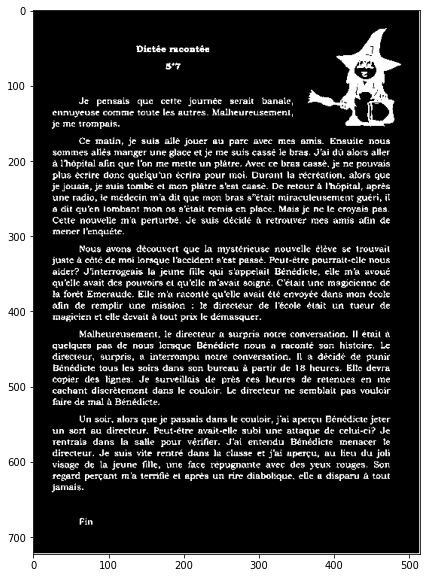

In [42]:
plot_image(img)

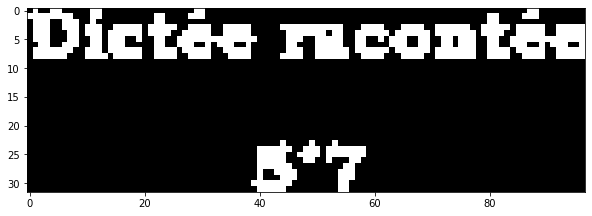

Dictée rucontée s7 


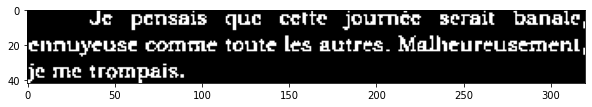

Je pensais que cette journée serait banale, ennuyeuse comme toute les autres. Malheureusement, Je me trompais. 


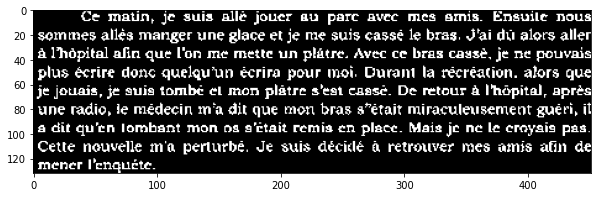

Ce matin, je suis allé jouer au parc avec mes amis. Ensuile nous sommes allés manger une glace et je me suis cassé le bras. J'ai du alors aller À lhôpital afin que l'on me mette un plâtre. Avec ce bras cassè, je ne pouvais plus écrire donc quelqu'un écrira pour moi. Durant la récréation. alors que je jouais, je suis tombé el mon plâtre s'est cassé. De retour à l'hôpital, après une radio, e médecin m'a dit que mon bras sétait miraculeusement guêri, l & dit qu'en lombant mon 0s s'était remis en place. Mais je ne le eraysis pes. Cette nouvelle m'a perturbé. Je suis décidé à retrouver mes amis afin de mener l'enquiête. 


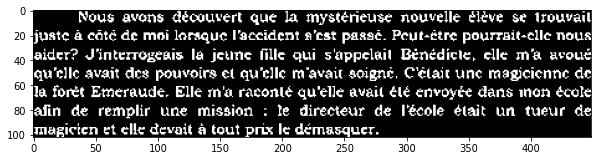

Nous avons découvert que la mystérieuse nouvelle élève se trouvail Jpste à côté de moï lorsque l'accident s'est passé. Peut-être pourrait-elle nous aider? J'interrogeais la jeunc fille qui s'appelail Bénédicte, clle m'a avoué quelle avait des pouvoirs ct qu'elle rm'avait scigné, C'était une magicionne de la forét Emeraude, Elle m'a raconté qu'elle avail élé envoyée dans mon école afin de remplir une mission : le directeur de l'école était un tueur de magicien et elle devait à tout prix le démasquer. 


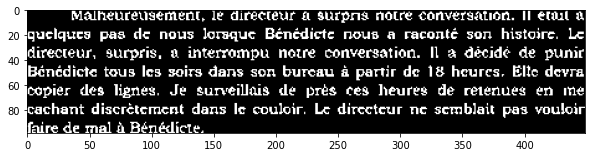

Malheureusement, le directeur à surpris notre conversation. Il était à Quelques pas de nous lorsque Bénédicte nous a raconté son histoire, Le directeur, surpris, à interrompu notre conversation. Il à décidé de punir Bénédicta tous les soirs dans son bureau à partir de 18 heures. Elte devra copier des lignes. Je surveillais de près ces heures de retenues en me eachant discrètement dans le couloir, Le directeur ne semblait pas vouloir faire de mal à Bénédicte. 


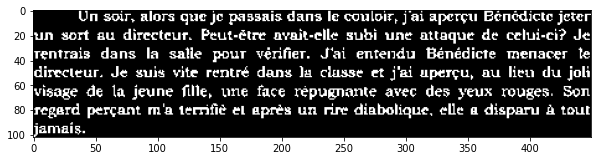

Un soir, alors que je passais dans le conloir, j'ai aperçu Bénédicte jerer un sort au directeur. Peut-être avait-elle subi une attaque de celui-ei? Je Tentrais dans la saîle pour vérifier. J'ai entendu Bénédicre menacer te dirceteur. Je uis vite rentré dans la classe et j'ai uperçu, au lieu du joli visage de la jeune fille, une face répugnante avec des yeux rouges. Son regerd perçant m'a ternifié el après un rire diabolique, elle a disparu à tour Jamais. 


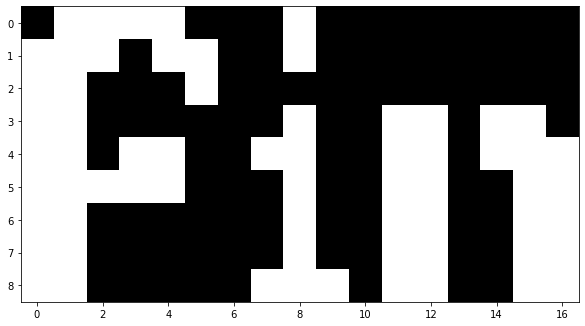

Fin 


In [43]:
paragraphs = []
bboxes = []

for b in set(d['block_num']):
    par_nums = set([p for (i, p) in enumerate(d['par_num']) if d['block_num'][i] == b])
    
    x1 = 100000
    y1 = 100000
    x2 = -1
    y2 = -1

    res = ''
    for p in par_nums:
        par_content = {k: [x for i, x in enumerate(v) 
                           if (d['block_num'][i] == b) and (d['par_num'][i] == p)] 
                       for k, v in d.items()}

        cur_line = 0
        for i in range(len(par_content['text'])):
            line_num = par_content['line_num'][i]
            txt = par_content['text'][i]
            x = par_content['left'][i]
            y = par_content['top'][i]
            w = par_content['width'][i]
            h = par_content['height'][i]
        
            if line_num != cur_line:
                cur_line = line_num

            if txt.strip() == '':
                continue
                
            x1 = x if x < x1 else x1
            y1 = y if y < y1 else y1
            x2 = x+w if x+w > x2 else x2
            y2 = y+h if y+h > y2 else y2

            res += txt + ' '

    if res == '':
        continue
    
    paragraphs.append(res)
    bboxes.append((x1,y1,x2,y2))
    
    tmp = img[y1:y2, x1:x2]
    plot_image(tmp)
    print(res)

In [44]:
print(bboxes)
print('\n\n'.join(paragraphs))

[(137, 47, 234, 79), (25, 116, 345, 158), (22, 169, 474, 301), (25, 312, 474, 414), (26, 426, 475, 525), (25, 539, 475, 641), (62, 675, 79, 684)]
Dictée rucontée s7 

Je pensais que cette journée serait banale, ennuyeuse comme toute les autres. Malheureusement, Je me trompais. 

Ce matin, je suis allé jouer au parc avec mes amis. Ensuile nous sommes allés manger une glace et je me suis cassé le bras. J'ai du alors aller À lhôpital afin que l'on me mette un plâtre. Avec ce bras cassè, je ne pouvais plus écrire donc quelqu'un écrira pour moi. Durant la récréation. alors que je jouais, je suis tombé el mon plâtre s'est cassé. De retour à l'hôpital, après une radio, e médecin m'a dit que mon bras sétait miraculeusement guêri, l & dit qu'en lombant mon 0s s'était remis en place. Mais je ne le eraysis pes. Cette nouvelle m'a perturbé. Je suis décidé à retrouver mes amis afin de mener l'enquiête. 

Nous avons découvert que la mystérieuse nouvelle élève se trouvail Jpste à côté de moï lorsque 

../Exemples/Ex_Maths/IMG_20210329_123828.jpg


o 1 : Souligne le COD dans la phrase. 

PRRTE Snicind TN SAREN - A it 
;w-«wﬂ i MR, 

chauffeur boit de I'eau. b) Lafille offm}un beau at re~ W’ 
a‘ng %e partir, le gargon voulut prondes - 
n supe™- 
: Relie le: 

ultat de: 
fractions: Exercice: donner le rés 

CQmpmﬁdN‘¢‘ 
nooe LSy = 
e o ST N) 
1 _— 2 
listre &. i _;73_+_~: (b D 
5 +5°: ﬁ—"’b"é 







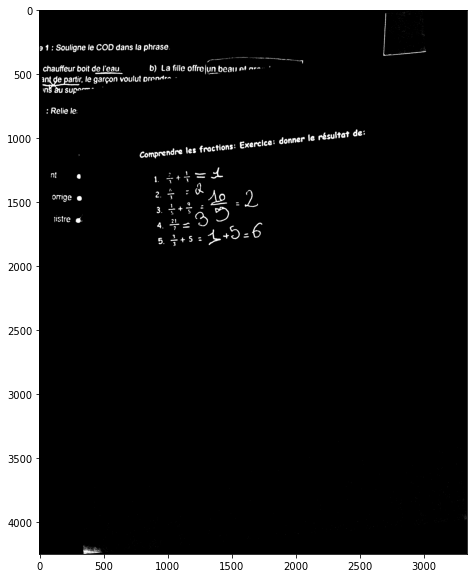

end in 10.3s

../Exemples/Ex_Maths/IMG_20210329_122221.jpg


Comprendre les fractions: Exercice: donner le résultat de: 



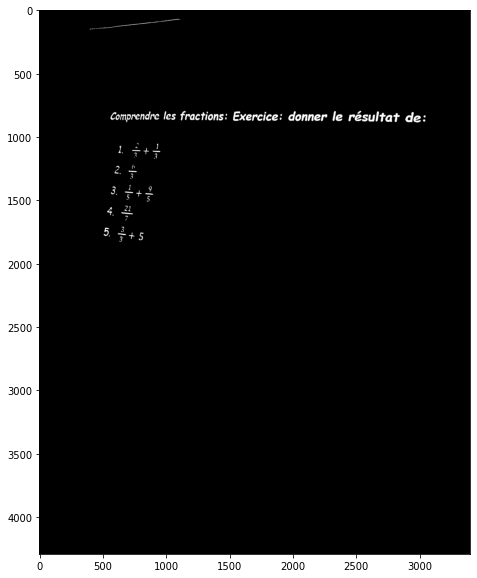

end in 5.2s

../Exemples/Ex_Maths/IMG_20210329_123818.jpg


Comprendre les fractions: Exercice: donner le résultat de: 



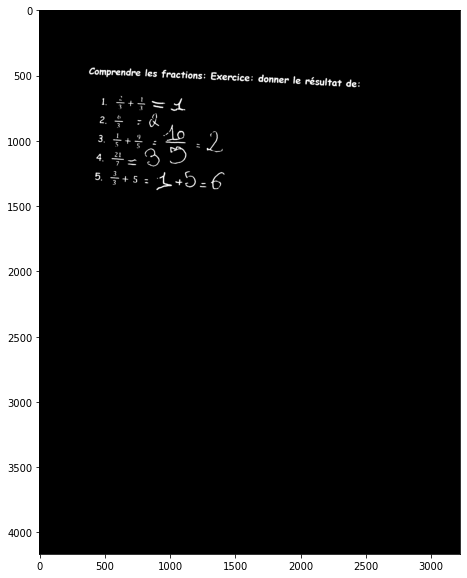

end in 5.0s

../Exemples/Ex_Maths/IMG_20210329_122227.jpg


Comprendre les fractions: Exercice: donner le résultat de: 

+ 
w]| - 

w|e 
+ 
Y 

o b w N 
<+ 
o 



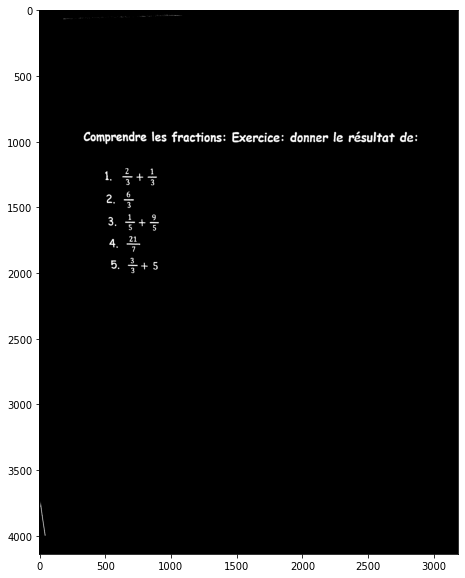

end in 6.1s

../Exemples/Ex_Maths/IMG_20210329_122202.jpg


Comprendre les fractions: Exercice: donner le résultat de: 

L < +5 
2. + 
3. —+ = 
4, - 
5. =+ 5 



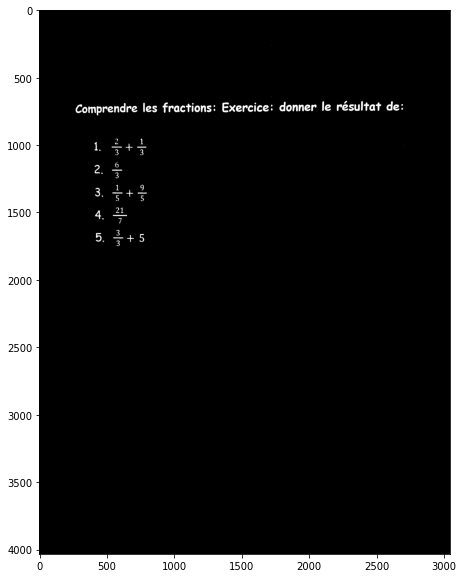

end in 5.1s

../Exemples/Ex_Maths/IMG_20210329_122715.jpg




Comprendre les fractions: Exercice: donner le résultat de: 

L S+ 
2. + 
3. —++¢ 
4 
5. <+ 5 



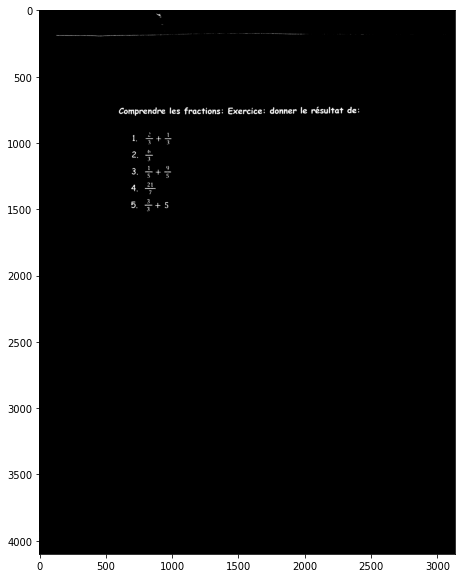

end in 5.4s

../Exemples/Ex_Maths/IMG_20210329_122724.jpg


Comprendre les fractions: Exercice: donner le résultat dc: 

L <+ 
2. + 
3. ++ = 
4, - 
5. =+ 5 



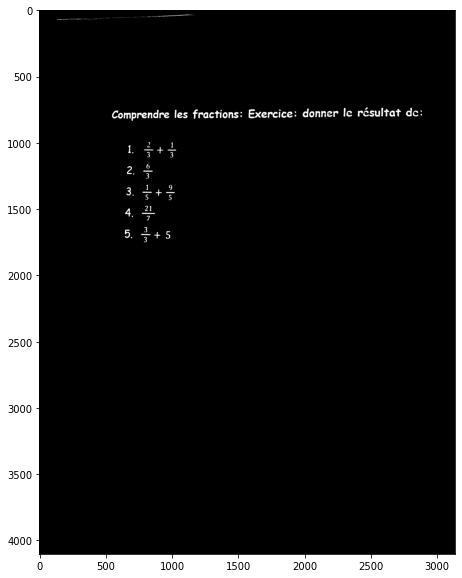

end in 6.1s

../Exemples/Ex_Maths/IMG_20210329_123813.jpg
No text found
end in 21.0s

../Exemples/Ex_Maths/IMG_20210329_122157.jpg


Comprendre les fractions: Exercice: S DT - TE 

1. +5 
2 £ 
3. -+ % 
4 = 
5. ++5 



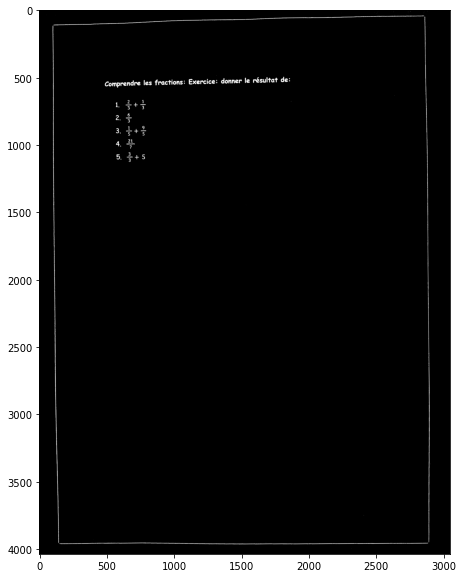

end in 5.2s

../Exemples/Ex_Maths/IMG_20210329_122738.jpg
No text found
end in 10.0s

../Exemples/Histoire_Geo/IMG_20210329_122543.jpg


e 

La Gréce Antique 

. Le théatre grec 

Les pieces de thé3 
e th Atai s 
Grecs des Temps Ancien{;aat - g'rggque etaient tres appréciées dans I’ Antiquité. Le 
épopées des héros. L Bpremalen’t tout particulierement les tragédies et le récit'dess 
. Les théatres, ou se déroulaient les représentations, avaient une 
b 

forme T3t IT: i 
particuliére en demi-cercle: ce sont les amphithéatres 

(e1Z-Tell e} 



| — Organisation d'un amphitheéatre 



IIl.  Lasociété grecque 

démocratie. Chacun est citoyen a partir de sa majorite et 

Les grecs ont inventé la 
a fagon de diriger la cite. 

peut faire valoir son opinion sur I 



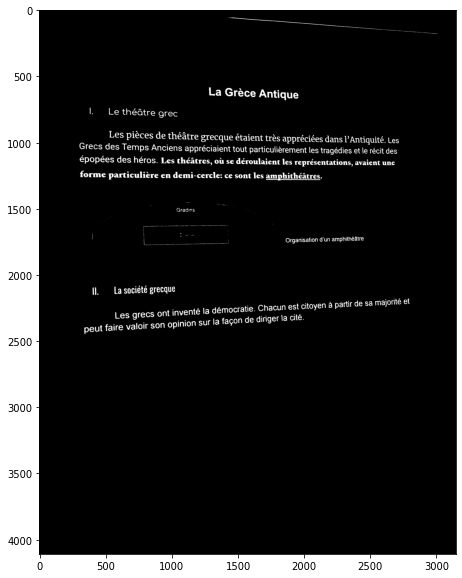

end in 11.6s

../Exemples/Histoire_Geo/IMG_20210329_123005.jpg


I, 

La Gréce Antique 

I.  Le thédtre grec 

Les piéces de théatre grecque étaient tres appréciées dans I’Antiquite. Les 
Grecs des Temps Anciens appréciaient tout particulierement les tragédies et le récit des 
épopées des héros. Les théatres, ou se déroulaient les représentations, avaient unc 

forme particuliére en demi-cercle: ce sont les amphithéatres. 



Organisation d'un amphithéatre 

La société grecque 

Les grecs ont inventé la démocratie. Chacun est citoyen a partir de sa majorité et 

peut faire valoir son opinion sur la fagon de diriger la cité. 



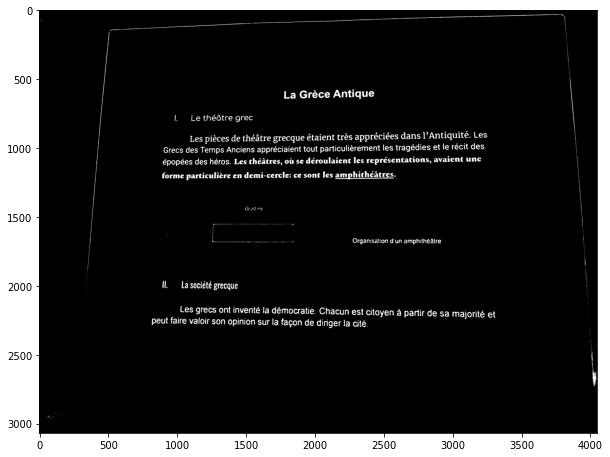

end in 10.3s

../Exemples/Histoire_Geo/IMG_20210329_122940.jpg
No text found
end in 28.0s

../Exemples/Histoire_Geo/IMG_20210329_123000.jpg


Il 

La Gréce Antique 

I, Le thédtre grec 

Id . h Ld .« 2 , . 3 -, 
Les piéces de théatre grecque éetaient tres appreciees dans I’Antiquite. Les 
Grecs des Temps Anciens appréciaient tout particuliérement les tragédies et le récit des 
epopées des héros. Les théatres, ou se déroulaient les représentations, avaient une 

forme particuliére en demi-cercle: ce sont les amphithéatres. 

Gradins 

i - 
i T e 
} 



/ 

Organisation d'un amphithéatre 
La société grecque 

Les grecs ont inventé la démocratie. Chacun est citoyen a partir de sa majorité et 

peut faire valoir son opinion sur la fagon de diriger la cité. 



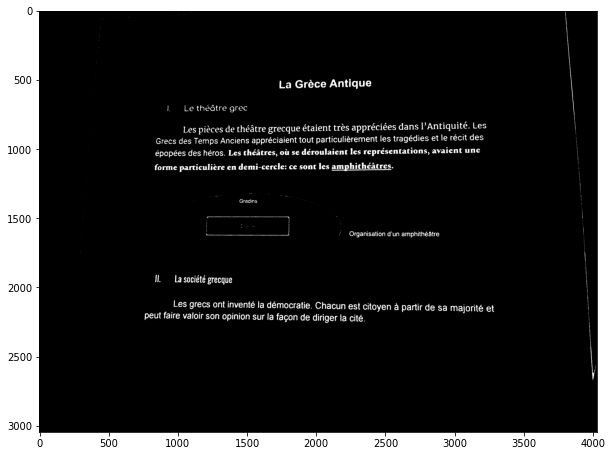

end in 10.3s

../Exemples/Histoire_Geo/IMG_20210329_122932.jpg


L i et i e i 
i 

(BN el (:-Tol- WXt { [ [V]:] 

. Le thédtre grec 

Les pieces de théatre grecque étaient trés appréciées dans I’Antiquité. Les 
Grecs des Temps Anciens appréciaient tout particulierement les tragédies et le récit des 
épopées des héros. Les théatres, ou se déroulaient les représentations, avaient une 

forme particuliére en demi-cercle: ce sont les amphithéatres. 

Grading 

e 
Lm,___j Organisation d'un amphithéatre 

IIl.  Lasociété grecque 

Les grecs ont inventé la démocratie. Chacun est citoyen a partir de sa majorité et 
peut faire valoir son opinion sur la fagon de diriger la cité. 

e e 



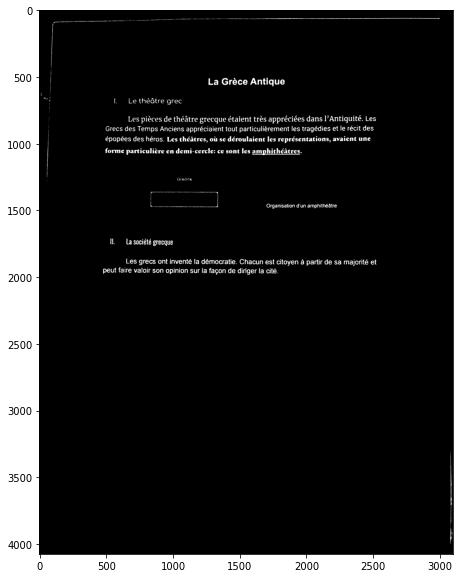

end in 10.4s

../Exemples/Histoire_Geo/IMG_20210329_122524.jpg




o SR A Yy ([ [T1:) 

i E G0 o) (0 (R EV R N sl T[T M S 
_nt tout particuliérement les tragédies et le récit des 
1 + s théatres, ol se déroulaient les représentations, avaient une 

--+ «n demi-cercle: ce sont les amphithéatres. 

Jrganisation d'un amphithéatre 

ll.  Llasociété grecque 

Les grecs ont inventé la démocratie. Chacun est citoyen a partir de sa majorité et 
peut faire valoir son opinion sur |a fagon de diriger la cité. 



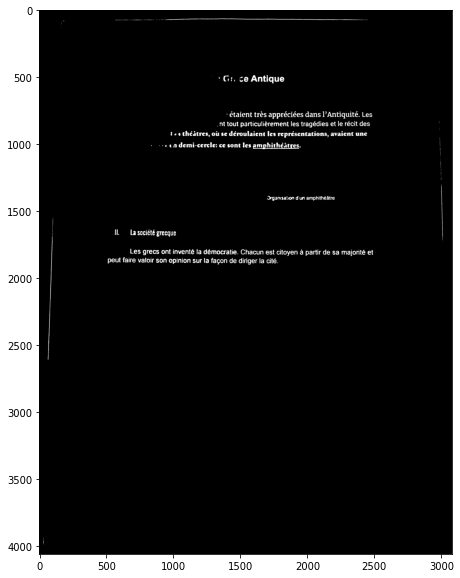

end in 8.3s

../Exemples/Histoire_Geo/IMG_20210329_122536.jpg


La Gréce Antique 

I Lethédtre grec 

Les piéces de théatre grecque étaient trés appréciées dans I’Antiquité. Les 
Grecs des Temps Anciens appréciaient tout particuliérement les tragédies et le récit des 
épopées des héros. Les théitres, ou se déroulaient les représentations, avaient une 

forme particuli¢re en demi-cercle: ce sont les amphithéatres. 

[€1£:Te]1a13 



Organisation d'un amphithéatre 

il lasociété grecque 

Les grecs ont inventé la démocratie. Chacun est citoyen a partir de sa majorité et 
peut faire valoir son opinion sur la fagon de diriger la cité. 





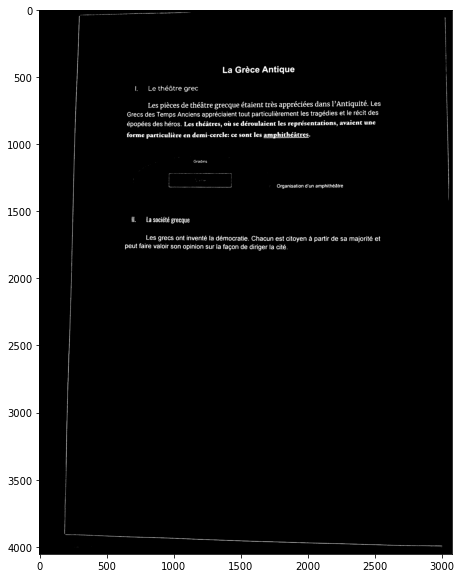

end in 9.4s

../Exemples/Dictee/IMG_20210329_122324.jpg


Dictée: Le petit chaperon rouge 

La grand-mére du petit chaperon rouge était trés malade. Elle demanda a sa 
petite-fille, avec qui elle vivait, de lui apporter quelque chose pour la guérir. Elle I'avertit, . 
cependant, de faire attention au Grand Méchant Loup qui rodait dans les bois. Le loup IEICE]] 

peur aux villageois des alentours depuis des années. Jusqu'a présent, aucun des chasseurs 
n‘avait reussi a 'abattre. 

Le petit chaperon rouge se mit donc en route pour aider sa grand-mere. Elle redressa son 

capuchon et le plaga sur sa téte. Elle s'engouffra dans les bois rapidement. C’est la qu'elle 
entendit un bruit. Elle se retourna mais ne vit rien. 

Quand elle rentra avec le remeéde, sa grand-mére était au lit. Elle lui demanda d’approcher. 
Le petit chaperon rouge remarqua qu’elle avait de grandes dents et de grandes oreilles. Sa 
voix était bien plus grave. Elle se rendit alors compte que ce n’était pas sa grand-mer

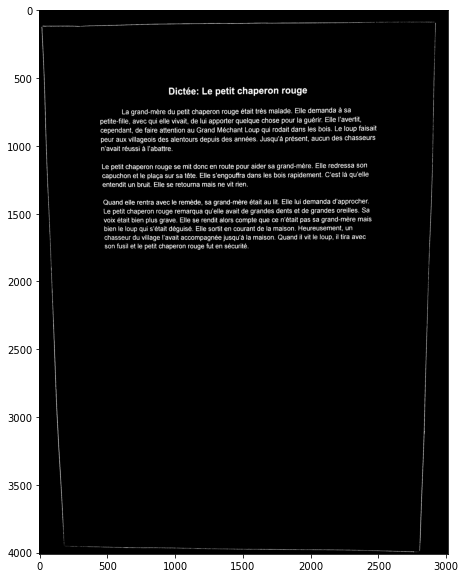

end in 15.9s

../Exemples/Dictee/IMG_20210329_122825.jpg
No text found
end in 17.2s

../Exemples/Dictee/IMG_20210329_122839.jpg


° 

4 

I —————— 

Dictée: Le petit chaperon rouge 

La grand-mére du petit chaperon rouge était trés malade. Elle LB ER Y] 
petite-fille, avec qui elle vivait, de lui apporter quelque chose pour la guérir. Elle l'avertit, 
cependant. de faire attention au Grand Méchant Loup qui rodait dans les bois. Le loup faisait 
peur aux villageois des alentours depuis des années. Jusqu'a présent, aucun des chasseurs 

n'avait réussi a 'abattre. 

Le petit chaperon rouge se mit donc en route pour aider sa grand-mére. Elle redressa son 
capuchon et le plaga sur sa téte. Elle s’engouffra dans les bois rapidement. C'est |a qu'elie 
entendit un bruit. Elle se retourna mais ne vit rien. 

Quand elle rentra avec le reméde, sa grand-mere était au lit. Elle lui demanda d'approcher. 
Le petit chaperon rouge remarqua qu'elle avait de grandes dents et de grandes oreilles. Sa 
voix

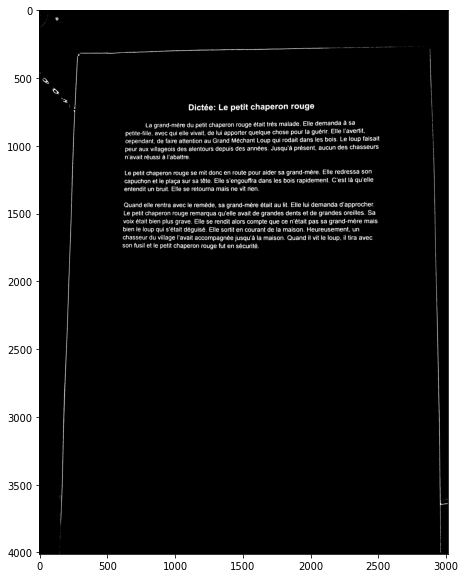

end in 16.2s

../Exemples/Dictee/IMG_20210329_122828.jpg


(D] 103 (-T- T R o T (i o3 g EoT ol do T g g U Lo [ 

La grand-meére du petit chaperon rouge était trés malade. Elle demanda a sa 
petite-fille, avec qui elle vivait, de lui apporter quelque chose pour la guérir. Elle I'avertit, 
cependant, de faire attention au Grand Méchant Loup qui rodait dans les bois. Le loup faisait 
peur aux villageois des alentours depuis des années. Jusqu’'a présent, aucun des chasseurs 
QEVENRCEITI R TE () 

(R oIS (1 WPl oLl (o g W e IN o [-I TN g1 e [ol g TR CTa W (o0 (- oTo U I =Tl [T T Wo 2= 1ol Ba U1 (0 = SR ¢=To [ = ST o) 
(e==Tolu ol glol g =T QIR ol FoTor WETOT - I () (O =Y SRS =T aTo (o101 - Wo EETa R =R o To R =T oo [=T 4o 1T o | A O =T G - W PN =11 2] 
entendit un bruit. Elle se retourna mais ne vit rien. 

Quand elle rentra avec le reméde, sa grand-mére était au lit. Elle lui demanda d’approcher. 
Le petit chaperon rouge remarqua qu’elle avait de grandes dents et de grandes oreilles. Sa 
v

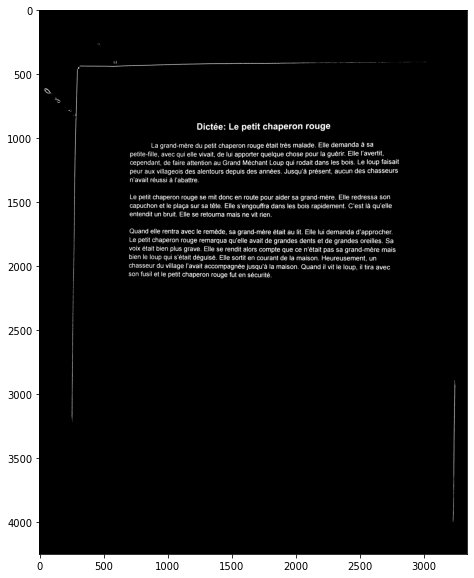

end in 17.4s

../Exemples/SVT/IMG_20210329_123138.jpg


Les plantes 

1. De quoi est composée la plante? 

La plante est composee: 
= d'une partie souterraine qui s’étend (parfois trés loin de I'endroit ol se trouve la plante en surface), 

d'une partie en surface (tige, feuilles.graines. fruits.fleurs) 

2. De quoi a besoin la plante? 

Le soleil permet a la plante de récupérer de I'énergie pour se développer. 

Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

2.2. Oxygéne 

Tout comme le soleil, 'oxygéne est essentiel pour la survie de la plante. 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller ou elles veulent, la 

croissance de la plante peut étre empécheée. 



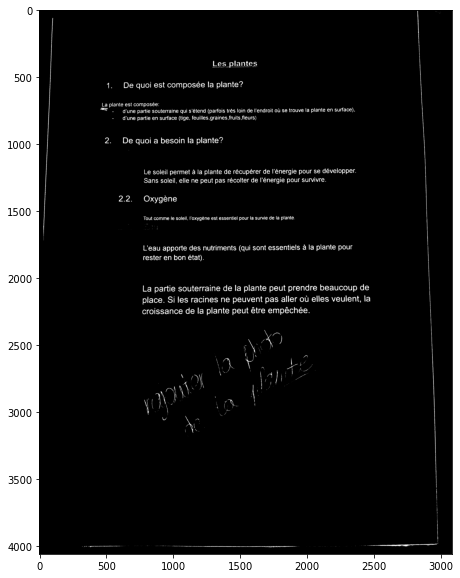

end in 11.9s

../Exemples/SVT/IMG_20210329_122617.jpg




Les plantes 

1. De quoi est composée la plante? 

La plante est composée: 

d'une partie souterraine qui s'étend (parfois trés loin de I'endroit ou se trouve la plante en surface), 
d’'une partie en surface (tige, feuilles,graines, fruits,fleurs) 

2. De quoi a besoin la plante? 

L 

Le soleil permet a la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

2.2. Oxygéne 

Tout comme le soleil, I'oxygéne est essentiel pour la survie de la plante. 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller ou elles veulent, la 
croissance de la plante peut étre empéchee. 





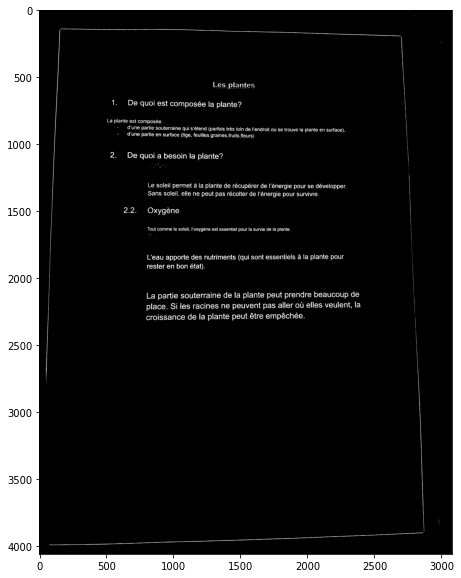

end in 11.9s

../Exemples/SVT/IMG_20210329_122614.jpg




Les plantes 

1. De quoi est composée la plante? 

- Bolbo 1) CRCIS B olely g ofo TR 
- d'une partie souterraine qui s'étend (parfois trés loin de I'endroit ol se trouve la plante en surface), 
- d'une partie en surface (tige, feuilles,graines,fruits,fleurs) 

2. De quoi a besoin la plante? 

2.2. 

Le soleil permet & la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I’'énergie pour survivre. 

(@) 4V/e[=141°] 

Tout comme le soleil, I'oxygéne est essentiel pour la survie de la plante. 

i 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller ou elles veulent, la 
ol (o] T [o W e R W ol ETal CR o LIN AL N =T g [o ST g [1H 







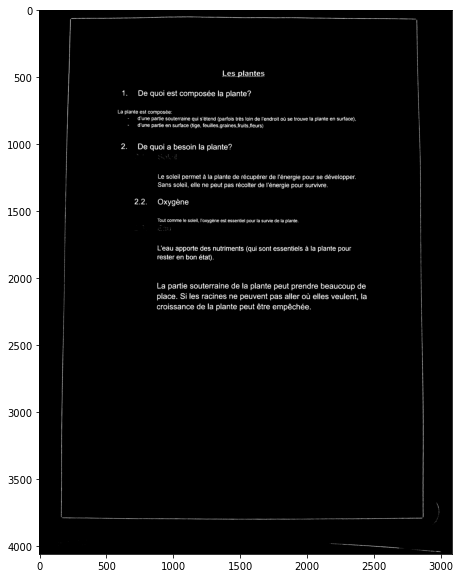

end in 13.0s

../Exemples/SVT/IMG_20210329_123021.jpg


Les plantes 

1. De quoi est composée la plante? 

EYIERICE- g elelaglofolY=I-K . 
p— d'une partie souterraine qui s'étend (parfois trés loin de I'endroit ou se trouve la plante en surface), 
d’une partie en surface (tige, feuilles,graines, fruits,fleurs) 

2. De quoi a besoin la plante? 

R R S R E R E R CR CRE IR CRECA e (R oJe VT Re [V < [o]of o] T8 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

2.2. Oxygéne 

Tout comme le soleil, 'oxygeéne est essentiel pour la survie de la plante. 

PO S 
Ladbd 

L'eau apporte des nutriments (qui sont essentiels & la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller ot elles veulent, la 
croissance de la plante peut étre empéchée. 



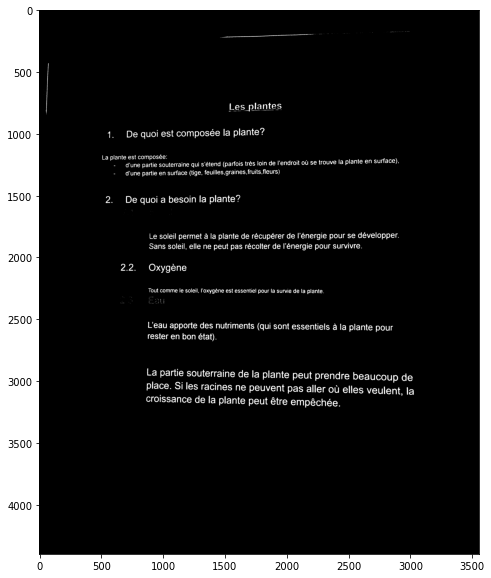

end in 13.0s

../Exemples/SVT/IMG_20210329_122633.jpg




Les plantes 

ela plante? 

quoi est compose 

1. De 
roit o se trouve la plante en surface). 

est compose® ‘étend (parfois rés Join de I'end 

La plante ' ' 
| i» souterraine qui s . ' 
- ;:nrf ;ﬁf:gf:n surface (tige, feuilles, grames,frwts.ﬂeurs) 
2. De quoi a besoin la plante? 
o evagf 

NCHED 

Le soleil permet 4 la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

VRN 0) 4"y 

Tout comme le soleil, 'oxygéne est essentiel pour la survie de la plante 

T 

L'eau apporte des nutri 
utriment j : 
rester en bon étaf) S (qui sont essentiels 4 |a plante pour 



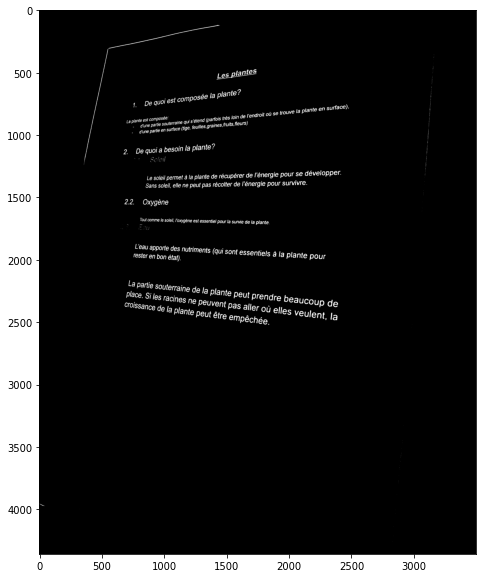

end in 11.2s

../Exemples/SVT/IMG_20210329_122621.jpg


De quoi 
est COmposge |5 plante? 

La plante est composge: 

- d‘ . 
d’une Partie souterrain 
une partie en surfag 

€ qui s'étend (parf 
' partois tres |oj 
e (ti A sloinde it ot 
(tige, eu‘“es.graines,fruns o :rsl)endrott Ou se trouve la plante en ht 
‘ Surface), 

2. ' 
| De quoi a besoin la plante? 

Le soleil permet 2 
et a la plante de récupé 
Sans solei récupérer de 'énergie pour se dé 
oleil, elle ne peut pas récolter de 'énergie gouf suw?\?rgevelopper' 

PV ©)'\e 141 

Tout comme le soleil, 'oxygéne est essentiel pour la survie de la plante. 

'eau apporte des nutriments (qui sont essentiels a 1a plante pour 

rester en bon état). 

ante peut ENE beaucoup de 

T IR CACEY 
veulent, 1a 

es racines nN€ peuvent pas aller ou elles 
e de la planté peut étre empéchee. 

La partie 
place. Sil 
croissanc 



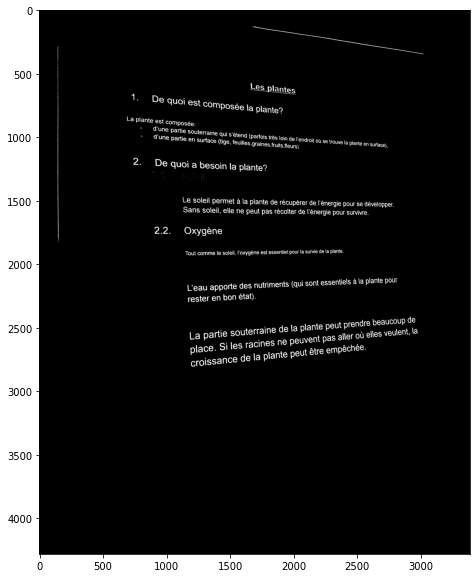

end in 12.4s

../Exemples/SVT/IMG_20210329_122629.jpg


- 

Les P [ g']]lf es 

e? 
;  Dequol est composee la plant 

’ la 
arfois trés loin de I'endrolt ou se trouve 

mposee 
ines.fruits,ﬂeurs) 

[ plante €51 €0 >0 ‘ 
o outerraine 

dune partie § ; , 
dune partie en surface (t 

VUK stend (P 
ige. fouilles.gra 

5 De quoi 8 besoin la plante? 

£ 

Le soleil permet & la plante de récupérer de I'énergie pour sé o [V =1 0] o] o =1 8 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

e Tin] 
Ay 

(@ Yol hl 
1out comme le soleil. Ioxygéne est essentiel pour la survie de la JolE:Tai (2] 

L'eau apporte des nutriments 

rester en bon étaf) (qui sont essentiels a la plante pour 

AL surface), 

e 



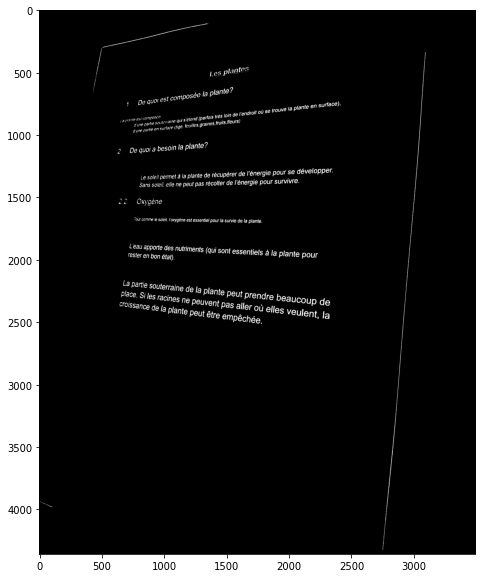

end in 11.9s

../Exemples/SVT/IMG_20210329_123025.jpg


| W o] FeTa) (=1 

1. De quoi est composeée la plante? 

La plante est composée: 

d'une partie souterraine qui s'étend (parfois trés loin de I'endroit ou se trouve la plante en surface), 
d'une partie en surface (tige, feuilles,graines. fruits fleurs) 

2. De quoi a besoin la plante? 

2.2 

Le soleil permet a la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

Oxygene 

Tout comme le soleil. I'oxygéne est essentiel pour la survie de la plante. 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller ou elles veulent, la 
croissance de la plante peut étre empéchée. 



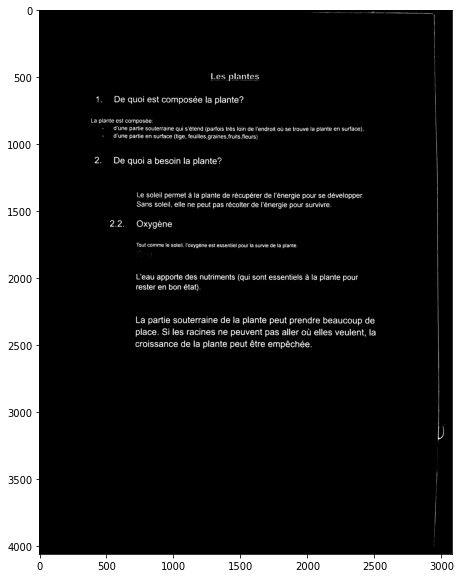

end in 12.9s

../Exemples/SVT/IMG_20210329_123017.jpg




LLes plantes 

1. De quoi est composée la plante? 

L a plante est composée | | 
d'une partie souterraine qui s'étend (parfois trés loin de Fendroit oG se trouve la plante en surface). 

d'une partie en surface (tige, feuilles graines fruits fleurs) 

2. De quoi a besoin la plante? 

Le soleil permet 4 la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

2.2. Oxygéne 

Tout comme le soleil, I'oxygéne est essentiel pour 1a survie de la plante. 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

La partie souterraine de la plante peut prendre beaucoup de 
place. Si les racines ne peuvent pas aller o elles veulent, la 
croissance de la plante peut étre empéchée. 





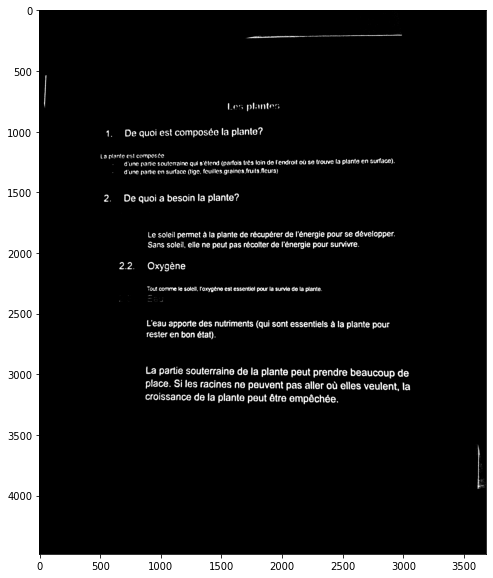

end in 12.7s

../Exemples/SVT/IMG_20210329_123029.jpg


Les plantes 

1. De quoi est composée la plante? 

La plante est composée: 

d'une partie souterraine qui s’étend (parfois trés loin de I'endroit ou se trouve la plante en surface), 
d'une partie en surface (tige, feuilles,graines. fruits fleurs) 

2. De quoi a besoin la plante? 

2.2. 

Le soleil permet a la plante de récupérer de I'énergie pour se développer. 
Sans soleil, elle ne peut pas récolter de I'énergie pour survivre. 

Oxygéne 

Tout comme le soleil, 'oxygéne est essentiel pour la survie de la plante. 

Lo iy 
i :‘;5,: 

L'eau apporte des nutriments (qui sont essentiels a la plante pour 
rester en bon état). 

=N o= IRV (e TN [N - Mol =T ol (N oW @ o] (=TaTo [ W oT-T= T8 [T 1 W o )0 [ 
place. Si les racines ne peuvent pas aller ou elles veulent, la 
croissance de la plante peut étre empéchée. 

U 



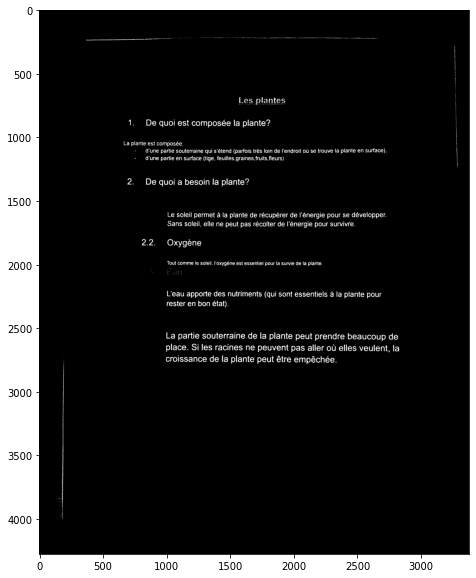

end in 13.2s

../Exemples/SVT/IMG_20210329_123132.jpg
No text found
end in 15.2s

../Exemples/Ex_COD/IMG_20210329_122814.jpg


e it A S R A 
e e et 

I 

Exercice: Le COD 



Exercice 1 : Souligne le COD dans la phrase. 
a) Le chauffeur boit de I'eau. b) La fille offre un beau et grand cadeau. 
c) Avant de partir, le gargon voulut prendre son petit-dejeuner. 
I L T g Lo AR = TV =Te (S C e [VR T 

Exercice 2 : Relie les verbes aux COD qui leur correspondent. 

Je mange ° e Des pommes 
Il conduit ] e Lacommande 
Les enfants vont ° e La voiture 
Le professeur corrige e e Se promener 
Le serveur enregistre e e Les devoirs 

e e b e e et et 



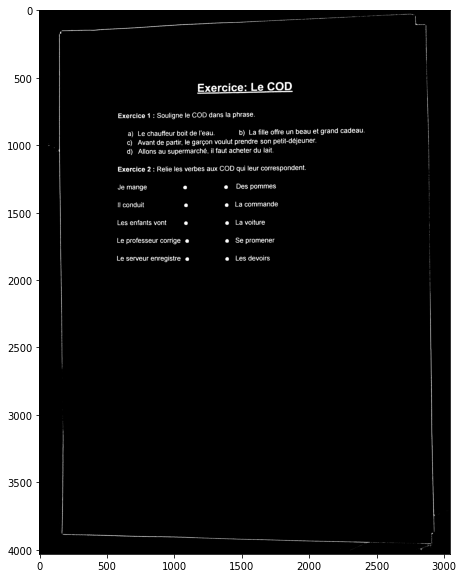

end in 10.4s

../Exemples/Ex_COD/IMG_20210329_122809.jpg
No text found
end in 17.0s

../Exemples/Ex_COD/IMG_20210329_122251.jpg




Exercice: Le COD 



Exercice 1 : Souligne le COD dans la phrase. 

)RR 10 IO g oTol o [SH T TR b) La fille offre un beau et grand cadeau. 

c) Avant de partir, le gargon voulut prendre son petit-déjeuner. 
d) Allons au supermarché, il faut acheter du lait. 

Exercice 2 : Relie les verbes aux COD qui leur correspondent. 

Je mange o o Des pommes 
Il conduit (-] o Lacommande 
Les enfants vont ° o La voiture 
Le professeur corrige o o Se promener 
Le serveur enregistre o o Les devoirs 



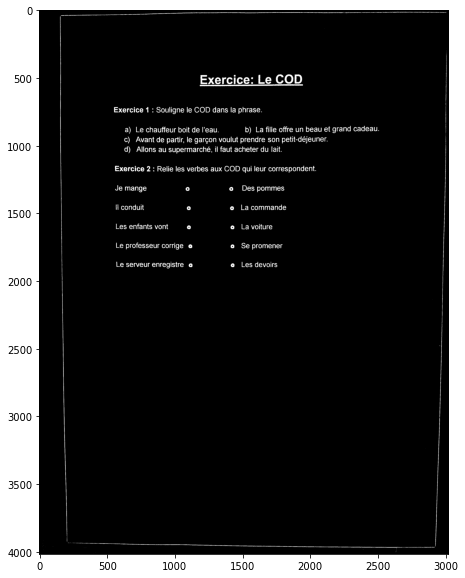

end in 9.2s

../Exemples/Ex_COD/IMG_20210329_123624.jpg








Exercice: Le COD 

Exercico 1 : Souligne le COD dans la phrase. 
M“‘“”mww MMW 

a) Le chauffeur boit de l'eau. b) La fille offre}un beau et grand cat:te':an}3 
-déjeuner. | 

,C) Avang %e partir, le gargon voulut prendre son peti 
d) Allon supermarché, il faut acheter du lait. 

Exercice 2 : Relie les verbes aux COD qui leur correspondent. 

Je mange o~ ~—o Des pommes 
Il conduit La commande 
Les enfants vont I RV} (]2 
Le professeur corrige Se promener 

Le serveur enregistre Les devoirs 



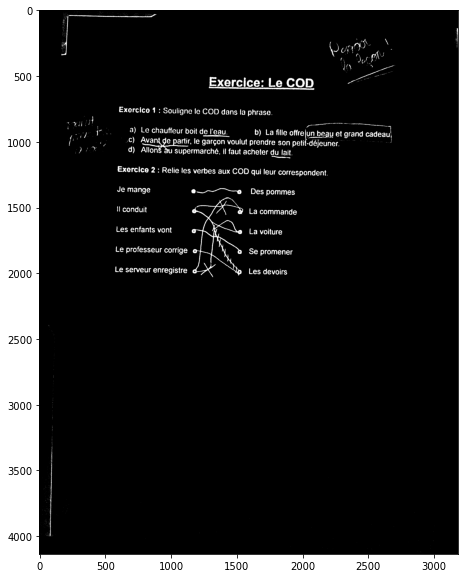

end in 10.2s

../Exemples/Ex_COD/IMG_20210329_122300.jpg


—._‘M...—_—.,,_W.WA,.“....A.M..\M 

- 

[ C (- H MR {0 D) 

Exercice 1 : Souligne le COD dans la phrase. 

a) Le chauffeur boit de I'eau. b) La fille offre un beau et grand cadeau. 
¢) Avant de partir, le gargon voulut prendre son petit-déjeuner. 
d) Allons au supermarché, il faut acheter du lait. 

Exercice 2 : Relie les verbes aux COD qui leur correspondent, 

Je mange ° o Des pommes 
Il conduit ° o Lacommande 
Les enfants vont ° o La voiture 
Le professeur corrige e © Se promener 

Le serveur enregistre o 

Les devoirs 



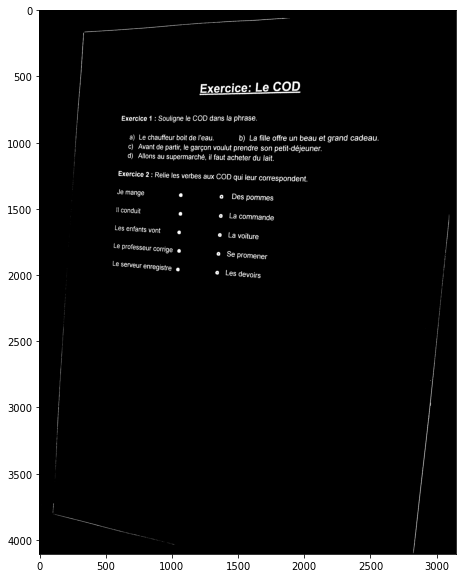

end in 10.0s

../Exemples/Ex_COD/IMG_20210329_123633.jpg




|2 Il [of- 1 RN (0] 0] 

Exercice 1 : Souligne le COD dans la phrase. 

il o 
L . i”: a) Le chauffeur boit de I'eau. b) La fille offret n beau et grand cadeau§ 
/; el s T 0) Avang %e partir, le gargon voulut prendre son petit-déjeurier. ~ = 
YO d) Allon supermarché, il faut acheter du lait. 



i 

Exercice 2 : Relie les verbes aux COD qui leur correspondent. 

Je mange o0——— ~—o Des pommes 
N 
Il conduit | La commande 
Les enfants vont La voiture 
Le professeur corrige Se promener 

Le serveur enregistre Les devaoirs 





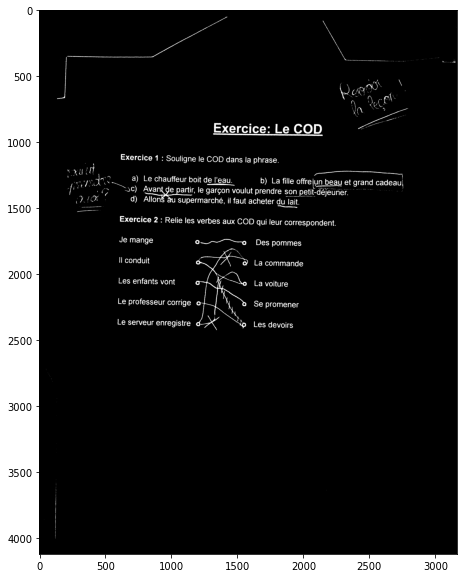

end in 10.8s

../Exemples/Ex_COD/IMG_20210329_122755.jpg
No text found
end in 10.9s

../Exemples/Ex_COD/IMG_20210329_122306.jpg


Exercice: Le COD 



Exercice 1 : Souligne le COD dans la phrase. 
a) Le chauffeur boit de I'eau. b) La fille offre un beau et grand cadeau. 
c) Avant de partir, le gargon voulut prendre son petit-dejeuner. 
I ST Uyl R R TN T (S C e VRET & 

Exercice 2 : Relie les verbes aux COD qui leur correspondent. 

Je mange o] o Des pommes 
Il conduit o] o Lacommande 
Les enfants vont o] oI W= RVIe1 (V] (= 
Le professeur corrige o o Se promener 

WY TRVCTU ol CTe [ (S Lo IO LYo [SAV/o] (£ 



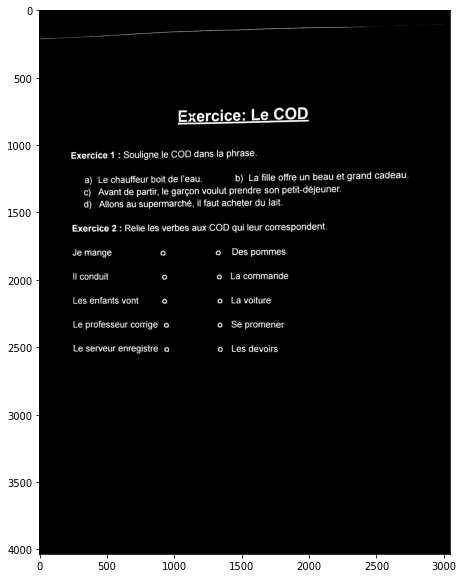

end in 9.3s

../Exemples/Present_indicatif/IMG_20210329_122401.jpg


Le présent de 'indicatif 
Ce temps est utilise pour: 
< Exprimer une vérité générale: 
> EX: Le ciel est bleu. 

En aodat, il fait chaud 

< Parler d’'une action en train de se dérouler: 
> Ex: Le chauffeur démarre la voiture. 

E".z Cz x”’~”’v3 














Verbes du 3eme 
L H 
ex: prendre 

Verhes du 2eme 
[ {11]1[H 
Y el ilally 

- 

Verhes du 1er groupe 
ex: parler 






Je 

— 
- 

I1/Elle/On 

Nous 



parlons {[ICEe]g ]S prenons 
SE11[<74 finissez prenez 
parlent finissent prennent 

Attention: || existe des verbes avec des formes irréguliéres comme étre, avoir, aller, etc. 

\Yfebk 

Ils/Elles 

Etre Avoir 
Je suis Ni:]] 
Tu es DKL 
I/EIle/On est Il/Elie/On 

Nous sommes Nous avons 
Vaous étes Vous avez 
lls/Elles sont lis ont 





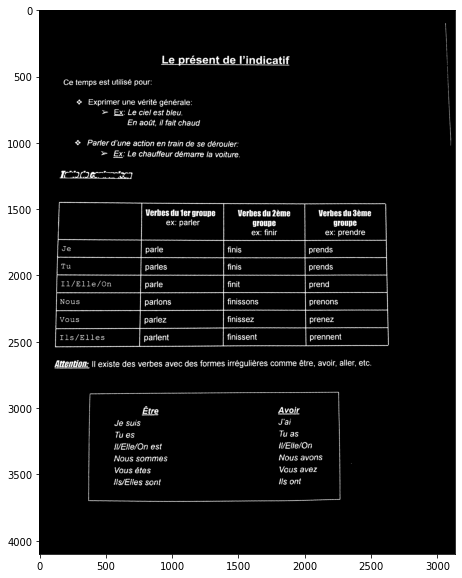

end in 11.7s

../Exemples/Present_indicatif/IMG_20210329_122910.jpg


o R CLLL % est utilisé pour: 

» Exprimer 
) » EXx: Le ciel est bleu. 

dérouler: 

ction en train de S€ 
[ER e 

o Parlerduné a 
> Ex Le chauffeur démarre 
















verbes du Jemc 
groupe 
ex: prendre 





Verhes du 2éme 
groupe 
ex: finir 

Verhes du 1er 1 (11117 
ex: parler 



Il/Elle/On 







Nous 




Vous 

Ils/Elles 
a . 
parlent ¢ ssent — 
—nnem 

e ———————— $ 
L t 











Etre 










Je suis 
df 
II\II/EHE/O" est ICE) 
0 S 
y us somme S e 
0us étes YElle/On 
Is/Elles son t Nous 3 vons 
Vou Sa 
d/e7 



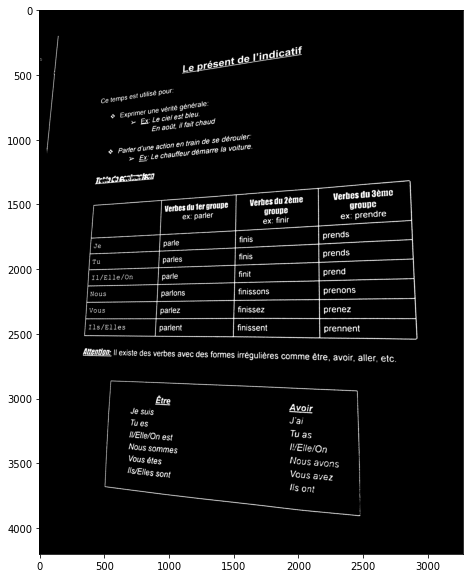

end in 12.0s

../Exemples/Present_indicatif/IMG_20210329_122337.jpg


Le présent de I'indicatif 

Ce temps est utilise pour: 

< Exprimer une verité générale: 
> EX: Le ciel est bleu. 
En aodt, il fait chaud 
< Parler d’une action en train de se dérouler: 
> Ex: Le chauffeur démarre la voiture. 

[ X/ 

s / 











Verbes du ter groupe 
ex: parler 

Verbes du 2eme 
{1 groupe 
S eRilslly ex: prendre 

Attention: | existe des verbes avec des formes irregulieres comme étre, avoir, aller, etc. 





Verhes du 3eme 






Etre 
Je suis 
Tu es 
Ii/ENe/On est 

y.\"{e]/4 
NE:7} 
Tu as 
H/Ele/On 
Nous avons 
Vous avez 
iis ont 

Nous sommes 
Vous étes 
lis/Elles sont 





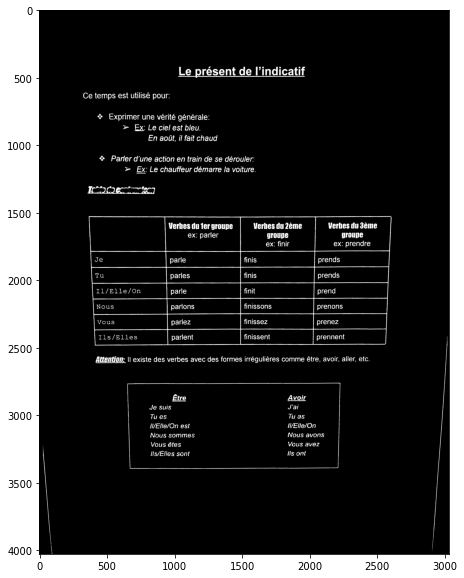

end in 10.8s

../Exemples/Present_indicatif/IMG_20210329_122915.jpg


Le présent de Iindicatif 

Ce temps est utilisé pour: 

< Exprimer une vérité génerale: 
> EX: Le ciel est bleu. 
En aodt, il fait chaud 

& Parler d’'une action en train de se dérouler: 
> Ex: Le chauffeur démarre la voiture. 























Vertes dn tergroups Vertiesdn2¢mo Verbesdo 3émo 
ex: parler groupns groupe 
ex: finir ex: prendre 

e 
Y C = 
R C 
R I S 
i oen o en  Jomen | 

Attention: ' existe des verbes avec des formes irméguliéres comme étre, avoir, aller, etc. 



Etre Avolr 

N/} SUis J'ai 
Tues T 
S0 XX I/Elle/On 

Vous étes Vous avez 
lis/Elles sont iis ont 



DTS — 



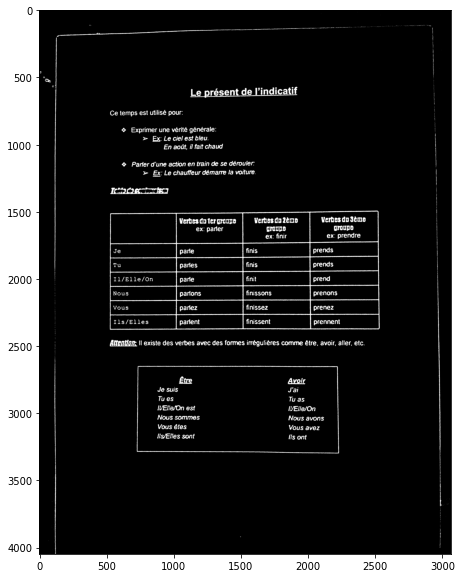

end in 11.1s

../Exemples/Present_indicatif/IMG_20210329_122904.jpg


Le présent de yindicayg 

Ce temps est utilisé pour: 

\ k3 
S Exprimer une verita genérale: 
> kX Le cief est bleu. 
En aodt, il tait chaud 

L 

Pad:sf d'une action en train de se dérouler 
Ex: Le chauffeur démarre 1a voiture. 










\erhes dutergroupe Vertiesdo2eme Verkesdndins 
ex: parler groupe graops 
ex: finir 

ex: prencre 

I1/Elle/On M_ prend 
ET (I N 

Attentign: i existe des verbes avec 















Etre | 
NE:1 
Tu es LElle/On 
JVENle/On es! Nous avons 
NoUS sommas Vous avel 
Vous otes iIs ont 

Is/Elles sont 

des formes irrégulieres comme gtre. avoir, aller. etc. 



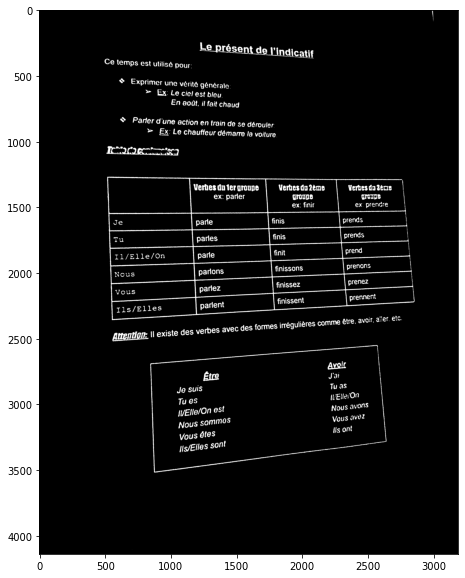

end in 11.5s

../Exemples/Present_indicatif/IMG_20210329_122857.jpg




Ce temps est utilisé pour 
¢ Exprimer une virma géntraie 
» Ex Lo ciel ezt dien 
En solt, # tsk chau) 

& Parter dure action en train 09 £8 O&Tuler 
> Ex Lo chaufewr Gimarre Id vO2.re 



e R e S T R 





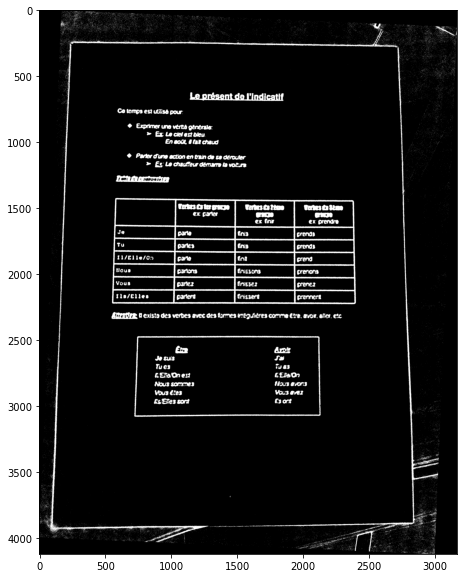

end in 8.5s

../Exemples/Present_indicatif/IMG_20210329_122406.jpg


Le présent de P'indicatif 

Ce temps est utilisé pour: 

< Exprimer une vérité générale: 
> EX: Le ciel est bleu. 
En aoat, il fait chaud 

< Parler d'une action en train de se dérouler: 
> Ex: Le chauffeur démarre la voiture. 

~w. e Wy 





'R ] 
groupe 
ex: prendre 

Verhes du 2eme 
groupe 
ex: finir 

Verhes du Ter groupe 
ex: parler 
















Altention: | existe des verbes avec des formes irrégulieres comme étre, avoir, aller, etc. 






Etre Avoir 
Je suis J'ai 
Tu es Tu as 
II/Elle/On est Ii/Ele/On 

Nous sommes Nous avons 
Vous étes Vous avez 
lIs/Elles sont s ont 





- R 
PENNSRES s 



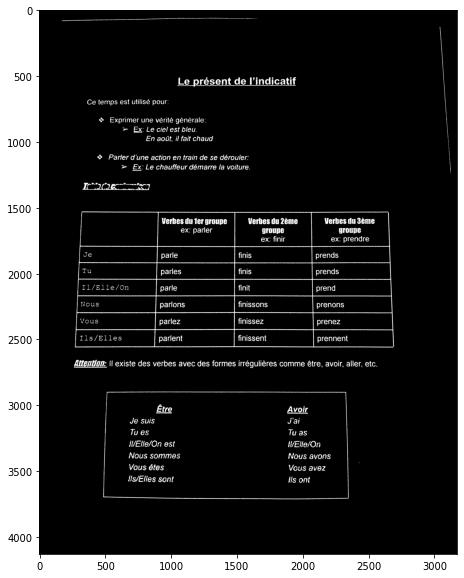

end in 10.9s

../Exemples/Present_indicatif/IMG_20210329_122343.jpg


Le présent de l'indicatif 
Ce temps est utilise pour: 
< Exprimer une vérité generale: 
> EX: Le ciel est bleu. 

En aodat, il fait chaud 

< Parler d’une action en train de se déerouler: 
> Ex: Le chauffeur démarre la voiture. 




















Verhes du 1er groupe Verhes du 2eme Verhes du 3éme 
ex: parler groupe groupe 
S eRilally ex: prendre 

z 
: 

Attention: || existe des verbes avec des formes irrégulieres comme étre, avoir, aller, etc. 








Etre Avoir 
Je suis J'af 
Tu es Tu as 
IWENe/On est IEHe/On 

Nous sommes Nous avons 
Vous étes Vous avez 
lls/Efles sont lis ont 





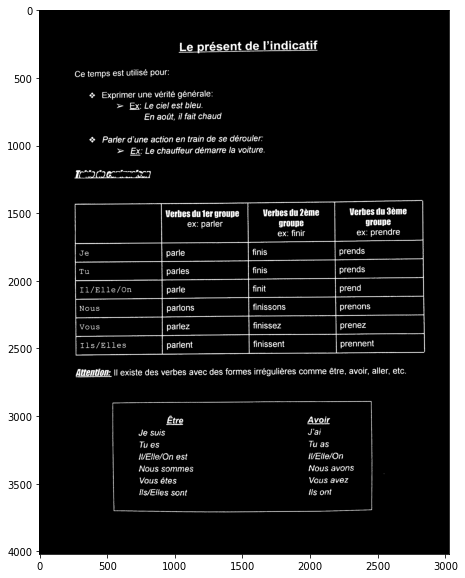

end in 10.7s

CPU times: user 6min 29s, sys: 15.2 s, total: 6min 45s
Wall time: 9min 8s


In [49]:
%%time
t = []

# ps = ['../Exemples/Ex_Maths/IMG_20210329_123818.jpg']
for p in all_files:
    print(p)
    
    t0 = time.time()
    try:
        img, res = pipeline(p, only_angle=False)     
        t.append(time.time() - t0)
        
        print('=============================================')
        print(format_pytesseract_dict_results(res))
        print('=============================================')
        plot_image(img)
        
    except Exception as e:
        print(e)
    
    print('end in %.1fs'%(time.time() - t0))
    print()

### Old code (keeping just in case)

27
4
2
1
8
24
24
11
3
4075
95 9


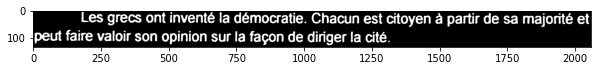

Les grecs ont inventé la démocratie. Chacun est citoyen à partir de sa majorité et
peut faire valoir son opinion sur la façon de diriger la cité.



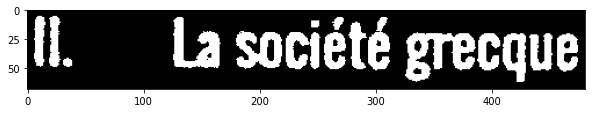

Ïl — Lassociété grecque



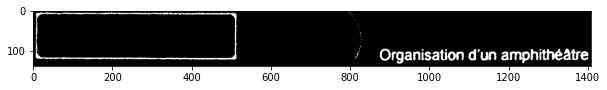

E::3 / Organisation d’un amphithéâtre



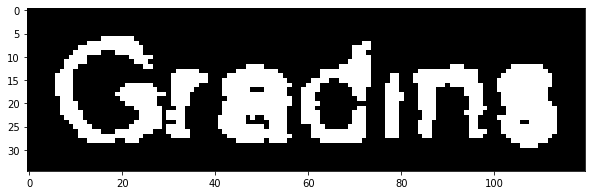

Gradimns



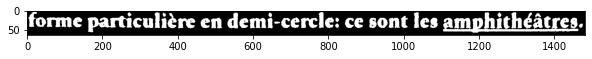

forme particulière en demi-cercle: ce sont les amphithéâtres.



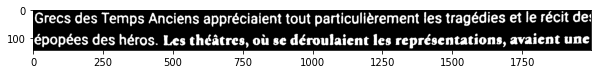

Grecs des Temps Anciens appréciaient tout particulièrement les tragédies et le récit de:
épopées des héros. Les théâtres, où se déroulaient les représentations, avaient une



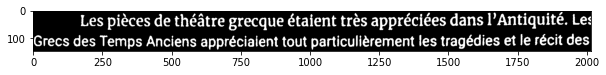

Les pièces de théâtre grecque étaient très appréciées dans l’Antiquité. Le:
Grecs des Temps Anciens appréciaient tout particulièrement les tragédies et le récit des



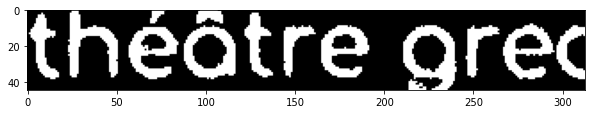

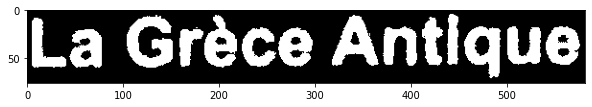

La Grèce Antique



In [97]:
p = all_files[14]
# p = '../Exemples/test.png'
# p = examples_path[1]

# Load image, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread(p)


image_no_shadow = preprocessing.remove_shadow(image)
image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)
angle = preprocessing.find_best_rotation_angle(image_gray)

image = preprocessing.rotate_img(image, angle=angle)
image = preprocessing.rotate_img(image, angle=180)
dark = increase_brightness(image, value=-int(image.mean() * 2 / 3) )
image_no_shadow = preprocessing.remove_shadow(dark)
image_gray = preprocessing.image_to_gray(image_no_shadow, threshold=True)
# e()

gray = cv2.cvtColor(dark, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = preprocessing.image_to_gray(blur, threshold=True)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=3)


# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

    
# plot_image(thresh)
# plot_image(dilate)
# plot_image(image)


img_h, img_w = thresh.shape
threshold_box = 0.9
bboxes = list()

def remove_useless_cnts(cnts, img_h, img_w, threshold_box):
    new_cnts = list()
    
    for (x,y,w,h) in cnts:
        if (w > img_w * threshold_box) or (h > img_h * threshold_box):
            continue
            
        new_cnts.append((x,y,w,h))
    
    return new_cnts

def merge_neighbors(cnts, img_h, img_w):
    # Estimation of a line height
    l_h = img_h * 0.0125 
    
    neighors = []
    for i, (x,y,w,h) in enumerate(cnts[:-1]):
        n = [i]
        for j, (x2,y2,w2,h2) in enumerate(cnts[i+1:]):
            if abs((y + h / 2) - (y2 + h2 / 2)) <= l_h * 1.5:
                n.append(i+1+j)
        neighors.append(n)
        
    idx_to_ignore = []
    for i, n in enumerate(neighors[:-1]):
        if i in idx_to_ignore:
            continue
        
        for j, n2 in enumerate(neighors[i+1:]):
            if len(set(n).intersection(n2)):
                neighors[i] = list(set(n).union(n2))
                idx_to_ignore.append(i+1+j)
                
                neighors[i+1+j] = None
        
    neighors = [n for n in neighors if n is not None]
    bboxes = []
    
    for n in neighors:
        x1 = 100000
        y1 = 100000
        x2 = -1
        y2 = -1
        print(len(np.array(cnts)[n]))
        for (x,y,w,h) in np.array(cnts)[n]:
            x1 = x if x < x1 else x1
            x2 = x+w if x+w > x2 else x2
            y1 = y if y < y1 else y1
            y2 = y+h if y+h > y2 else y2
         
        bboxes.append((x1,y1,x2,y2))
        
        
    return bboxes

    
cnts = [cv2.boundingRect(c) for c in cnts]
cnts = remove_useless_cnts(cnts, img_h, img_w, threshold_box)
bboxes = merge_neighbors(cnts, img_h, img_w)
print(img_h)
print(len(cnts), len(bboxes))

for (x1,y1,x2,y2) in bboxes:
    
    rect = image_gray[y1:y2, x1:x2]
    plot_image(rect)
    txt = extract_text_from_image(rect)
    print(txt)
    
#     b = {}
#     b['coord'] = (x,y,w,h)
#     b['res'] = txt
#     bboxes.append(b)